This notebook presents a step-by-step tutorial on using the developed packages for price forecasting.

In [74]:
# Add package folder to Python path
import sys
sys.path.append('./')
import forecasting as fr
import importlib
import pandas as pd
importlib.reload(fr.get_data)
importlib.reload(fr.model)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf

## Data acquisition

Import the data as a dataframe. The helper function cleans up the data from API and only gives price and volume data.

NG ESO API - The API is *inclusive* of start date and *exclusive* of the end date.

In [75]:
query_start_date = '2024-06-10'
query_end_date = '2025-06-10'

dcl_data = fr.get_data.get_historical_fr_data_price_volume(query_start_date, query_end_date)

/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/Energy_Price_Forecasting/Mine/Energy-Price-Forecasting/forecasting/get_data.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcl_data['clearingPrice'] = pd.to_numeric(dcl_data['clearingPrice'], errors='coerce')
/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/Energy_Price_Forecasting/Mine/Energy-Price-Forecasting/forecasting/get_data.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcl_data['clearedVolume'] = pd.to_numeric(dcl_data['clea

In [76]:
dcl_data.head()

,clearingPrice,clearedVolume
deliveryStart,,
2024-08-21 23:00:00,2.00,1261.0
2024-08-22 03:00:00,2.13,1366.0
2024-08-22 07:00:00,4.35,1207.0
2024-08-22 11:00:00,1.51,1176.0
2024-08-22 15:00:00,2.31,1177.0


## Naive forecast

In [77]:
# Calculate the naive forecast using a rolling average for both price and volume
# Give the data for days -1 (index -7 onwards) to -8 (until index -49) and verify the forecast for day 0.

price_naive_forecast = fr.model.rolling_average_multi_timeperiod(7, 6, dcl_data['clearingPrice'].iloc[:-6])
volume_naive_forecast = fr.model.rolling_average_multi_timeperiod(7, 6, dcl_data['clearedVolume'].iloc[:-6])

# Compare the naive forecast with the actual values for day 0
# Calculate the MAPE
mape_price_naive = mean_absolute_percentage_error(dcl_data['clearingPrice'].iloc[-6:], price_naive_forecast)
mape_volume_naive = mean_absolute_percentage_error(dcl_data['clearedVolume'].iloc[-6:], volume_naive_forecast)

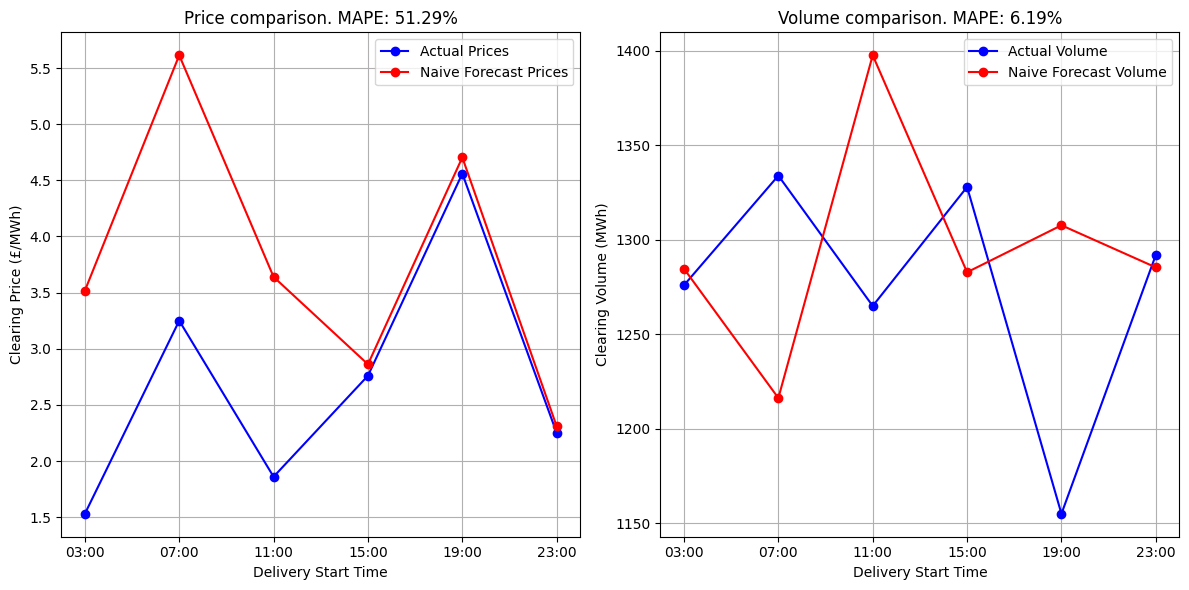

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

timestamp = dcl_data.index[-6:]

# First the price plot
ax1.plot(timestamp, dcl_data['clearingPrice'].iloc[-6:], marker='o', linestyle='-', color='blue', label='Actual Prices')
ax1.plot(timestamp, price_naive_forecast, marker='o', linestyle='-', color='red', label='Naive Forecast Prices')

ax1.set_xlabel('Delivery Start Time')
ax1.set_ylabel('Clearing Price (£/MWh)')
ax1.set_title('Price comparison. MAPE: {:.2f}%'.format(mape_price_naive * 100))
ax1.legend()

ax1.set_xticks(timestamp) # Shows ticks only at actual data points
ax1.set_xticklabels(timestamp.strftime("%H:%M"), rotation=0) # Shows only the hour and minute
ax1.grid(True)

# Next the volume plot
ax2.plot(timestamp, dcl_data['clearedVolume'].iloc[-6:], marker='o', linestyle='-', color='blue', label='Actual Volume')
ax2.plot(timestamp, volume_naive_forecast, marker='o', linestyle='-', color='red', label='Naive Forecast Volume')

ax2.set_xlabel('Delivery Start Time')
ax2.set_ylabel('Clearing Volume (MWh)')
ax2.set_title('Volume comparison. MAPE: {:.2f}%'.format(mape_volume_naive * 100))
ax2.legend()
ax2.set_xticks(timestamp) # Shows ticks only at actual data points
ax2.set_xticklabels(timestamp.strftime("%H:%M"), rotation=0) # Shows only the hour and minute
ax2.grid(True)


plt.tight_layout()
plt.show()

The naive forecast is... well... naive. It gives an error of over 51% for the prices which is quite rubbish. It's also worth noting from the above figure that the predictions are very much off for the first three time-steps, but quite good for the last three timesteps.

The forecast is quite accurate for volume prediction, however.

Time to use a deep learning model.

## Forecasting using LSTM

Autocorrelation analysis (in a different notebook) suggests that the time-series data has a good correlation with lags of 6, 12, and 18 timesteps. So we use that to generate lagged features for our LSTM model.

In [79]:
lag_times = [6, 12, 18]

# Create lagged features for the specified lag times
for lag in lag_times:
    dcl_data[f'Price_lag_{lag}'] = dcl_data['clearingPrice'].shift(lag)
    # dcl_data[f'Volume_lag_{lag}'] = dcl_data['clearedVolume'].shift(lag)

# Just one lag for volume
dcl_data[f'Volume_lag_{6}'] = dcl_data['clearedVolume'].shift(6)

print("Lagged features created for both price and volume lags:", lag_times)

# Drop rows that don't have enough history for the lagged features
dcl_data = dcl_data.dropna()

# print("First few rows of the dataframe are: \n", dcl_data.head())
# print("Last few rows of the dataframe are: \n", dcl_data.tail())

Lagged features created for both price and volume lags: [6, 12, 18]


In [80]:
# Split the dataset into training and validation sets
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(dcl_data):
    X_train, X_valid = dcl_data.iloc[train_index], dcl_data.iloc[test_index]

print("Train shape:", X_train.shape, "Validation shape:", X_valid.shape)
print("Original data shape:", dcl_data.shape)

Train shape: (1448, 6) Validation shape: (724, 6)
Original data shape: (2172, 6)


In [81]:
# Define the LSTM parameters
WINDOW_SIZE = 24
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [82]:
# Generate the dataset windows that go into the LSTM model

series_train = X_train['clearingPrice'].values
X_lag_train = X_train.drop(columns=['clearingPrice', 'clearedVolume']).values
series_train = tf.convert_to_tensor(series_train, dtype=tf.float32)
X_lag_train = tf.convert_to_tensor(X_lag_train, dtype=tf.float32)

series_valid = X_valid['clearingPrice'].values
X_lag_valid = X_valid.drop(columns=['clearingPrice', 'clearedVolume']).values
series_valid = tf.convert_to_tensor(series_valid, dtype=tf.float32)
X_lag_valid = tf.convert_to_tensor(X_lag_valid, dtype=tf.float32)

train_set = fr.model.windowed_dataset_multi_input(
    series=series_train,
    X_lag_full=X_lag_train,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE
)

valid_set = fr.model.windowed_dataset_multi_input(
    series=series_valid,
    X_lag_full=X_lag_valid,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE
)

In [89]:
# Get the LSTM model
lstm_model = fr.model.get_LSTM_model(
    window_size= WINDOW_SIZE,  
    learning_rate= 1e-6, 
    momentum= 0.9, 
    num_lag_features= dcl_data.shape[1] - 2)
print(lstm_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence input      │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 64)    │        256 │ sequence          │
│                     │                   │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     33,024 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lag input           │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        320 │ lag input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 74,945 (292.75 KB)

 Trainable params: 74,945 (292.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [90]:
# Train the model
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Get initial weights
init_weights = lstm_model.get_weights()

# Reset the weights
lstm_model.set_weights(init_weights)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= 10,
    restore_best_weights=True
)

# Fit the model
history = lstm_model.fit(
    train_set,
    epochs=100,
    validation_data=valid_set,
    # callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
     43/Unknown 1s 10ms/step - loss: 41.0158 - mae: 41.5143

/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 39.6751 - mae: 40.1734 - val_loss: 1.9172 - val_mae: 2.3733
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6992 - mae: 3.1685 - val_loss: 1.5069 - val_mae: 1.9477
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.1215 - mae: 1.5235 - val_loss: 1.8814 - val_mae: 2.3223
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0753 - mae: 1.4686 - val_loss: 1.8221 - val_mae: 2.2608
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0771 - mae: 1.4706 - val_loss: 1.8254 - val_mae: 2.2641
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0742 - mae: 1.4674 - val_loss: 1.8225 - val_mae: 2.2611
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0719 - mae: 1.4649 - val_loss: 1.8180 - val_mae: 2.2565
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0692 - mae: 1.4623 - val_loss: 1.8095 - val_mae: 2.2478
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0623

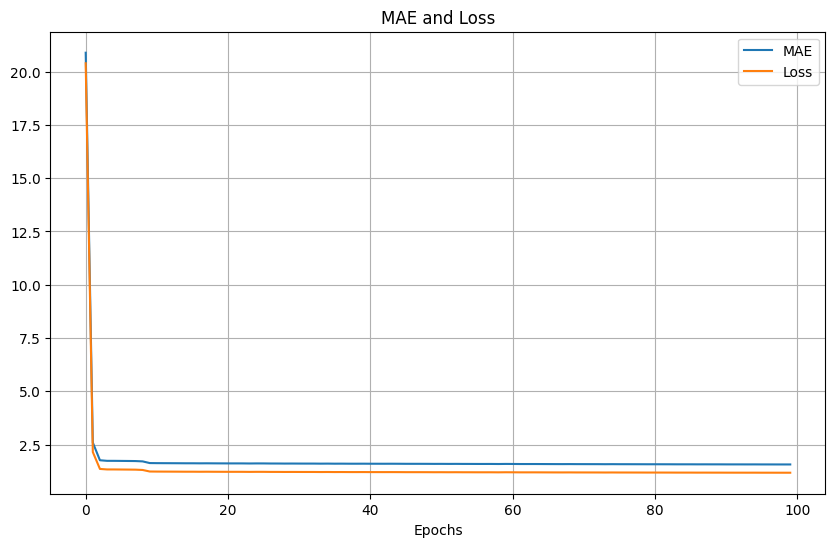

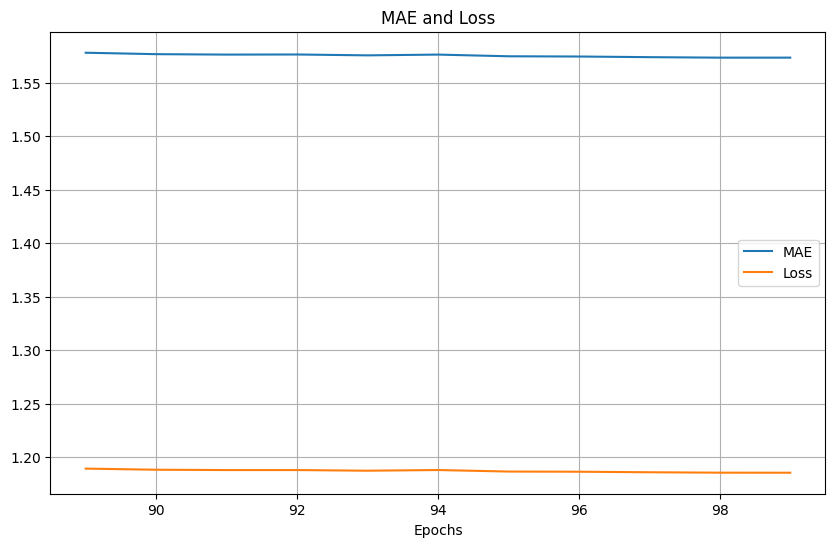

In [92]:
# Check if the training was successful by visualising the training history

# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
fr.get_data.plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )


# Only plot the last 10% of the epochs
zoom_split = int(epochs[-1] * 0.9)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
fr.get_data.plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )


In [93]:
lstm_forecast = fr.model.lstm_forecast_multi_input(
    model=lstm_model,
    series=series_valid,
    X_lag_full=X_lag_valid,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE
)

In [94]:
# Calculate the MAPE for the forecast for the last day (6 periods)
mape_forecast = mean_absolute_percentage_error(
    dcl_data['clearingPrice'].iloc[-6:],
    lstm_forecast[-6:]
)  
print(f"MAPE for LSTM forecast: {mape_forecast*100:.2f}%")

print(f"MAPE for naive forecast was: {mape_price_naive*100:.2f}%")

MAPE for LSTM forecast: 27.22%
MAPE for naive forecast was: 51.29%


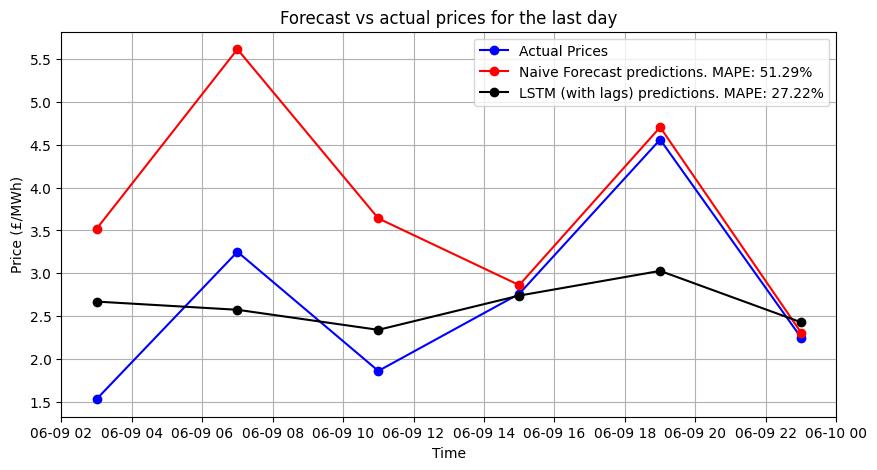

In [95]:
plt.figure(figsize=(10, 5))
plt.plot(timestamp, X_valid['clearingPrice'].iloc[-6:], marker='o', linestyle='-', color='blue', label='Actual Prices')
plt.plot(timestamp, price_naive_forecast, marker='o', linestyle='-', color='red', label='Naive Forecast predictions. MAPE: {:.2f}%'.format(mape_price_naive * 100))
plt.plot(timestamp, lstm_forecast[-6:], marker='o', linestyle='-', color='black', label='LSTM (with lags) predictions. MAPE: {:.2f}%'.format(mape_forecast * 100))
plt.title('Forecast vs actual prices for the last day')
plt.xlabel('Time')
plt.ylabel('Price (£/MWh)')
plt.legend()
plt.grid(True)
# Format x-tick labels as HH:MM
plt.show()